# Define parameters

In [1]:
from traffic_events import *

# ####################
# Defind parameters
# ####################

project_par = {
    'data_input_path'   :   '../Singapore_data/phase7/',
    'data_output_path'  :  './S07_dA_days',
    'fig_output_path'   :  './OutFigs',
    'stations'          :  {'S07':['1806']},
#     'stations'          :  {'S07':['2225']},#phase 1:1806; phase 2:2225
    'components'        :  ['Z'],
    
    'verbosity'         :  True,
    'local_timezone'    :  True,  # correct time zone to local time
#     'proj_time_bgn'     :  UTCDateTime(2020,4,19,0,0,0),   # section begin time
#     'proj_time_end'     :  UTCDateTime(2020,4,22,0,59,59), # section end time
    
}

processing_par = {

    # remove response
    'remove_response'   : False,
    'remove_singlef'    : False,
    
    # resampling
    'downsampling_rate' : 0.002,
    
    # highpass filter
    'freq_highpass'     : 0.1,

    # PSD
    'PSD_winlen'        : 24*3600, # second, time length for output PSD
    
    # identify footsteps
    'winlen_spc'        : 3600,  # sec, time window length for calculating spectrogram
    'winlen_events'     : 12*3600, # sec, time window length for counting events
    'sampleRate'        : 500,
    'notch_freq'        : 50,
    'qality_factor'     : 100,
    'sel_lfre'          : 30,
    'sel_hfre'          : 150,
    'prominence'        : 5,#5
    'distance'          : 8,
    'alp'               : 3,
    't_h'               : 15,
    'c0'                : 1,
    'd_ind'             : 6,
    'f_l'               : 10,
    'f_h'               : 80,
    'mu'                : 5,
    'std_h'             : 1.5,
    'vcar'              : 11.1,
    'vs'                : 180,
    'delta_t1'          : 3*3600,#19-7 p1,2 0*3600;p3new 20.5*3600;p4new 21*3600+2400,p5 8*3600;p6,7 3*3600
    'delta_t2'          : 12*3600,
    'nfft'              : 256,
    'nperseg'           : 256,
    'noverlap'          : 128,
    'pk_pct'            : 0.7,
    }

# Select two amplitude spectrum at two times from each traffic signal event

In [ ]:
# ######################
# Data processing flow
# ######################
%matplotlib inline


# initial DataProcessing class
dp = DataProcessing(project_par, processing_par, default_par)    

# get data list
dp.getdatalist()

for files in dp.data_list:
    
    dp.readdata(files)
    dp.preprocessing()
#     dp.high_pass()
    #dp.psd()
    dp.iso_traffic()
    
plt.close()   

# Q estimation

## Define data input, output path, and other parameters

In [2]:
from traffic_events import *
from matplotlib import colors
import matplotlib as mpl
from numpy import linalg as LA
import os


cmp='Z'
station = 'S07'
flag    = 'traffic'
flag_trace='trace'
flag_peaks='peaks'
flag_Q='Q'
flag_acp = 'accepted'

f_l=10 #lower frequency band of the data
f_h=80 #higher frequency band of the data

ax_f=np.load('ax_f.npy')
ia=int(np.where(ax_f>=f_l)[0][0])
ib=int(np.where(ax_f<=f_h)[0][-1])

# parameters for cleaning the data
ka_lpct=0.2 
ka_hpct=0.95
dy_pct=0.7

# use seismic data in 4-day long, 1-day moving window to estimate the daily Q
time_diff1   = 1*3600*24
time_diff2   = 4*3600*24

traffic_datapath = './S07_dA_days/'
data_output_path='./trace_S07_4days/'

for keys in [traffic_datapath, data_output_path] :
    if not os.path.exists(keys):
        print('creat %s' %keys)
        os.makedirs(keys)
        
starttime = UTCDateTime(2020,3,15,0,0,0)   # section begin time
endtime   = UTCDateTime(2020,11,10,0,0,0)   # section begin time

## Estimate Q statistically

In [ ]:
from numpy import linalg as LA
from scipy.optimize import leastsq
from scipy.optimize import minimize

def fit(X, params):
    return X.dot(params)

def cost_function(params, X, y):
    return np.sum(np.abs(y - fit(X, params)))

def residual_two_functions(pars, x, y):
    slope=pars[0]
    offset=pars[1]
    diff=[]
    for i in range(len(y)):
        dy=y[i]-(slope*x[i]+offset)
        diff.extend(list(dy))
    return(diff)
    
cmp = 'Z'
fig_size=(12,8)
fontsize=15
y_lim = 0.04

fig, ax = plt.subplots(figsize=fig_size)
daytime = []
line_num = 0
points = []
time_line = []
vs = 180
vm = 11.1
l = 1
t0 = 0.256
d_ind = 6
dr=np.sqrt(((d_ind+1)*t0*vm)**2+l**2)-np.sqrt((t0*vm)**2+l**2)
nline_num = int((endtime-starttime)/time_diff1)

for iline in range(0, nline_num):
    dA=[]
    acp0=[]
    acp=[]
    
    time_bg = starttime + iline*time_diff1
    time_ed = time_bg+time_diff2
    
    traffic_list = getdatalist(traffic_datapath, station, flag, time_bg, time_ed, cmp)
    print('traffic_list',traffic_datapath, station, flag, time_bg, time_ed, cmp)
    if traffic_list ==[]:
        continue
    else:
        daytime += [time_bg.datetime.date()]  # for legend
    
    for ipp in range(0, len(traffic_list)):
        traffic = np.load(traffic_list[ipp])
        dA.append(traffic['data'])
    dA_a=np.vstack((dA))
    k_a=np.zeros((len(dA_a)))
    c_a=np.zeros((len(dA_a)))
    for i in range(len(dA_a)):
        X = np.asarray([np.ones((ib-ia,)), ax_f[ia:ib]]).T
        y = dA_a[i,ia:ib]
        x0=np.array([0,0])
        output = minimize(cost_function, x0, args=(X, y),method='Nelder-Mead', tol=1e-7)
        y_hat = fit(X, output.x)
        dy=y-y_hat
        
        k_a[i] = output.x[1]
        c_a[i] = output.x[0]

    for i in range(len(k_a)):
        if (k_a[i] > 0):
            acp0.append(i)  
    for i in range(len(acp0)):
        if (k_a[acp0[i]] > np.quantile(k_a[acp0],ka_lpct)) and (k_a[acp0[i]] < np.quantile(k_a[acp0],ka_hpct)):# and (0<std_a[acp0[i]]<1.0):
            acp.append(acp0[i])

    y0 = np.zeros((ib-ia))
    yacp_al = []
    for j in range(len(acp)):#len(acp)
        y0 = k_a[acp[j]] * ax_f[ia:ib] + c_a[acp[j]]
        dy = np.abs(dA_a[acp[j],ia:ib] - y0)
        y_thr = np.quantile(dy,dy_pct)
        yacp = []
        for i in range(len(dy)):
            if dy[i] < y_thr:
                yacp.append(ia + i)
        yacp_al.append(yacp)
        
    
    par_init = np.zeros((2))
    x=[]
    for i in range(len(acp)):
        x.append(ax_f[yacp_al[i]])
    y=[]
    
    for i in range(len(acp)):
        y.append(dA_a[acp[i],yacp_al[i]])

    best, cov, info, message, ier = leastsq(residual_two_functions,
                                        par_init, args=(x, y),
                                        full_output=True)
    k=best[0]
    Q=vs*k/(np.pi*dr)
    print('estimated Q',Q)

    Q_title = '%s-%s-%s-%s-%s'%(station,flag_Q, time_bg.strftime("%Y.%m.%d.%H:%M:%S"),
                                  time_ed.strftime("%Y.%m.%d.%H:%M:%S"), cmp)
    path = data_output_path + Q_title
    np.savez(path, data=Q, ax1=np.array([]), time=time_bg.strftime("%Y.%m.%d.%H:%M:%S"), txt_hrd=Q_title)
    
    acp_title = '%s-%s-%s-%s-%s'%(station,flag_acp, time_bg.strftime("%Y.%m.%d.%H:%M:%S"),
                                  time_ed.strftime("%Y.%m.%d.%H:%M:%S"), cmp)
    path = data_output_path + acp_title
    np.savez(path, data=len(acp), ax1=np.array([]), time=time_bg.strftime("%Y.%m.%d.%H:%M:%S"), txt_hrd=acp_title)
    
    
 

# Plot all the parameters

## Q

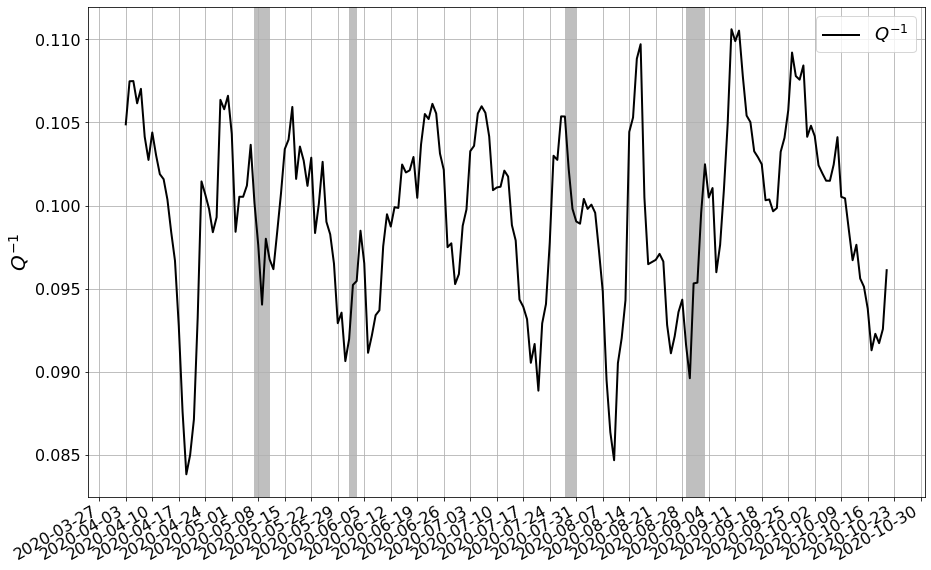

In [3]:
from traffic_events import *
from matplotlib import colors
import matplotlib as mpl
import pandas as pd

starttime_without_data1 = UTCDateTime(2020,5,7,0,0,0)   # no data begin time
endtime_without_data1   = UTCDateTime(2020,5,10,0,0,0)   # no data begin time
datelist_without_data1 = pd.date_range(starttime_without_data1.datetime, min(endtime_without_data1, UTCDateTime()).datetime, freq="D")


starttime_without_data2 = UTCDateTime(2020,6,1,0,0,0)   # no data begin time
endtime_without_data2   = UTCDateTime(2020,6,2,0,0,0)   # no data begin time
datelist_without_data2 = pd.date_range(starttime_without_data2.datetime, min(endtime_without_data2, UTCDateTime()).datetime, freq="D")


starttime_without_data3 = UTCDateTime(2020,7,28,0,0,0)   # no data begin time
endtime_without_data3   = UTCDateTime(2020,7,30,0,0,0)   # no data begin time
datelist_without_data3 = pd.date_range(starttime_without_data3.datetime, min(endtime_without_data3, UTCDateTime()).datetime, freq="D")

starttime_without_data4 = UTCDateTime(2020,8,29,0,0,0)   # no data begin time
endtime_without_data4   = UTCDateTime(2020,9,2,0,0,0)   # no data begin time
datelist_without_data4 = pd.date_range(starttime_without_data4.datetime, min(endtime_without_data4, UTCDateTime()).datetime, freq="D")

fig_size=(15,10)
fontsize=20
fig, ax = plt.subplots(figsize=fig_size)
daytime = []
line_num = 0
points0 = []
time_line = []
Q_list = getdatalist(data_output_path, station, flag_Q, starttime, endtime, cmp)

S07_df_Q=pd.DataFrame(columns=['time','Q'])   
    
for ipp in range(0, len(Q_list)):
    Q = np.load(Q_list[ipp])
    time = datetime.datetime.strptime(np.array2string(Q['time']),"'%Y.%m.%d.%H:%M:%S'")
    time1=time.strftime("%Y-%m-%d")
    S07_df_Q.loc[ipp,'time']=time1
    S07_df_Q.loc[ipp,'Q']=Q['data']
    points0 += [Q['data']]
    time_line += [time]

S07_df_Q.to_csv('./S07_df_Q.csv')

points0=np.array(points0)
line1,=ax.plot(time_line,points0, color='k',linewidth=2,label='$Q^{-1}$')

# beautify the x-labels
myFmt = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(myFmt)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))

ax.set_ylabel('$Q^{-1}$', fontsize=fontsize)
     
ax.tick_params(axis='both', which='major', labelsize=16)

# ax.set_ylim(8,12)

ax.grid(True)
fig.autofmt_xdate() 

for dbi in datelist_without_data1:
    plt.axvspan(dbi, dbi+datetime.timedelta(days=1),
                facecolor='gray', edgecolor=None,
                alpha=0.5, zorder=-5)

for dbi in datelist_without_data2:
    plt.axvspan(dbi, dbi+datetime.timedelta(days=1),
                facecolor='gray', edgecolor=None,
                alpha=0.5, zorder=-5)
for dbi in datelist_without_data3:
    plt.axvspan(dbi, dbi+datetime.timedelta(days=1),
                facecolor='gray', edgecolor=None,
                alpha=0.5, zorder=-5)

for dbi in datelist_without_data4:
    plt.axvspan(dbi, dbi+datetime.timedelta(days=1),
                facecolor='gray', edgecolor=None,
                alpha=0.5, zorder=-5)

plt.legend(handles=[line1],fontsize=18)
plt.savefig("Figure_NUS_Q.jpg", bbox_inches = 'tight',dpi=600)
plt.show()



## Rainfall data

In [4]:
import pandas as pd
from datetime import datetime

csv_filename = 'Rainfall_Temperature.csv'

headers = ['country_region_code','Date','Daily rainfall total (mm)','Temperature (°C)','Morning rainfall (mm)','Evening rainfall (mm)']

selected_change = 'Daily rainfall total (mm)'
selected_change1 = 'Temperature (°C)'

df = pd.read_csv(csv_filename,names=headers)
df['Date'] = df['Date'].map(lambda x: datetime.strptime(str(x), '%m/%d/%Y'))

x = df['Date']
y = df[selected_change]

y1 = df[selected_change1]

flag_rain = 'rainfall'
flag_temp = 'temp'
rainfall_output_path = './Rainfall_S07/'
rainfall_output_path_days = './Rainfall_S07_4days/'

for keys in [rainfall_output_path,rainfall_output_path_days] :
    if not os.path.exists(keys):
        print('creat %s' %keys)
        os.makedirs(keys)
        
starttime_r = UTCDateTime(2020,3,1,0,0,0)   # section begin time
endtime_r   = UTCDateTime(2020,11,10,0,0,0)   # section begin time        
oneday   = 3600*24

nline_num = int((endtime_r-starttime_r)/oneday)

for iline in range(0, nline_num):
    time_bg = starttime_r + iline*oneday
    time_ed = time_bg+oneday

    rain=y[iline]
    rain_title = '%s-%s-%s-%s-%s'%(station,flag_rain, time_bg.strftime("%Y.%m.%d.%H:%M:%S"),
                                  time_ed.strftime("%Y.%m.%d.%H:%M:%S"), cmp)
    path = rainfall_output_path + rain_title
    np.savez(path, data=rain, ax1=np.array([]), time=time_bg.strftime("%Y-%m-%d"), txt_hrd=rain_title)
    
    temp=y1[iline]
    temp_title = '%s-%s-%s-%s-%s'%(station,flag_temp, time_bg.strftime("%Y.%m.%d.%H:%M:%S"),
                                  time_ed.strftime("%Y.%m.%d.%H:%M:%S"), cmp)
    path = rainfall_output_path + temp_title
    np.savez(path, data=temp, ax1=np.array([]), time=time_bg.strftime("%Y-%m-%d"), txt_hrd=temp_title)
    

In [5]:
daytime = []
for iline in range(0, nline_num):
    rain0=[]
    temp0=[]
    time_bg = starttime_r + iline*time_diff1
    time_ed = time_bg+time_diff2
    
    rainfall_list = getdatalist(rainfall_output_path, station, flag_rain, time_bg, time_ed, cmp)
    temp_list = getdatalist(rainfall_output_path, station, flag_temp, time_bg, time_ed, cmp)
    if rainfall_list ==[]:
        continue
    else:
        daytime += [time_bg.datetime.date()] 
    for ipp in range(0, len(rainfall_list)):
        rain = np.load(rainfall_list[ipp])
        temp = np.load(temp_list[ipp])
        rain0.append(rain['data'])
        temp0.append(temp['data'])
    rainfall=np.sum((rain0))/len(rain0)
    temp=np.sum((temp0))/len(temp0)
    
    rain_title = '%s-%s-%s-%s-%s'%(station,flag_rain, time_bg.strftime("%Y.%m.%d.%H:%M:%S"),
                                  time_ed.strftime("%Y.%m.%d.%H:%M:%S"), cmp)
    path = rainfall_output_path_days + rain_title
    np.savez(path, data=rainfall, ax1=np.array([]), time=time_bg.strftime("%Y-%m-%d"), txt_hrd=rain_title)
    
    temp_title = '%s-%s-%s-%s-%s'%(station,flag_temp, time_bg.strftime("%Y.%m.%d.%H:%M:%S"),
                                  time_ed.strftime("%Y.%m.%d.%H:%M:%S"), cmp)
    path = rainfall_output_path_days + temp_title
    np.savez(path, data=temp, ax1=np.array([]), time=time_bg.strftime("%Y-%m-%d"), txt_hrd=temp_title)
    


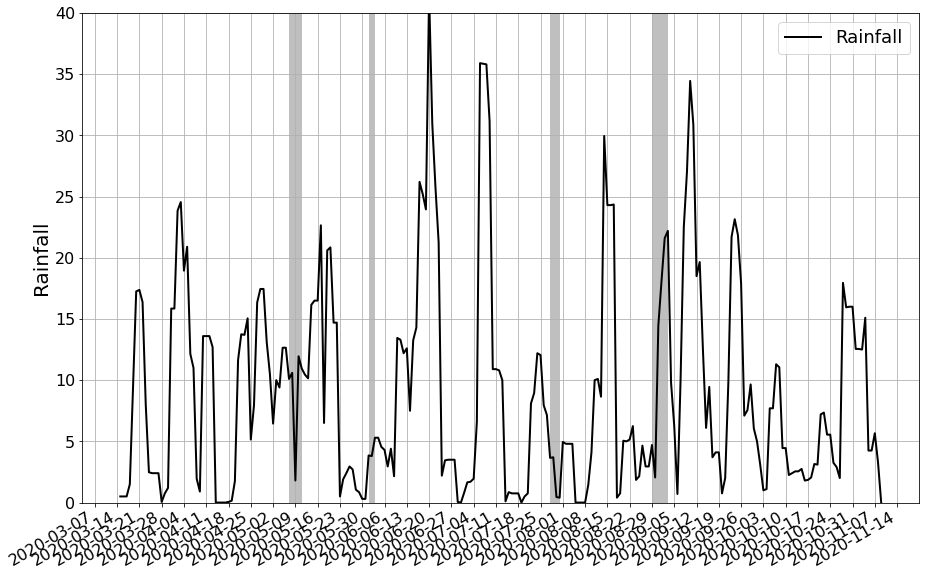

In [6]:
from traffic_events import *
from matplotlib import colors
import matplotlib as mpl

ylim_min2 = 0;
ylim_max2 = 40;
fig_size=(15,10)
fontsize=20

fig, ax = plt.subplots(figsize=fig_size)
daytime = []
line_num = 0
rainfall0 = []
time_line = []

rainfall_list = getdatalist(rainfall_output_path_days, station, flag_rain, starttime, endtime, cmp)

S07_df_rf=pd.DataFrame(columns=['time','Rainfall'])   
    
for ipp in range(0, len(rainfall_list)):
    rain= np.load(rainfall_list[ipp])
    time = datetime.datetime.strptime(np.array2string(rain['time']),"'%Y-%m-%d'")
    time1=time.strftime("%Y-%m-%d")
    S07_df_rf.loc[ipp,'time']=time1
    S07_df_rf.loc[ipp,'Rainfall']=rain['data']
    rainfall0+= [rain['data']]
    time_line += [time]

S07_df_rf.to_csv('./S07_df_rf.csv')   
rainfall0=np.array(rainfall0)
line1,=ax.plot(time_line,rainfall0, color='k',linewidth=2,label='Rainfall')

# beautify the x-labels
myFmt = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(myFmt)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.set_ylabel('Rainfall', fontsize=fontsize)    
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_ylim([ylim_min2,ylim_max2])

ax.grid(True)
fig.autofmt_xdate() 

for dbi in datelist_without_data1:
    plt.axvspan(dbi, dbi+datetime.timedelta(days=1),
                facecolor='gray', edgecolor=None,
                alpha=0.5, zorder=-5)
for dbi in datelist_without_data2:
    plt.axvspan(dbi, dbi+datetime.timedelta(days=1),
                facecolor='gray', edgecolor=None,
                alpha=0.5, zorder=-5)
for dbi in datelist_without_data3:
    plt.axvspan(dbi, dbi+datetime.timedelta(days=1),
                facecolor='gray', edgecolor=None,
                alpha=0.5, zorder=-5)

for dbi in datelist_without_data4:
    plt.axvspan(dbi, dbi+datetime.timedelta(days=1),
                facecolor='gray', edgecolor=None,
                alpha=0.5, zorder=-5)

plt.legend(handles=[line1],fontsize=18)
plt.savefig("Figure_NUS_rf.jpg", bbox_inches = 'tight',dpi=600)
plt.show()


## Traffic count

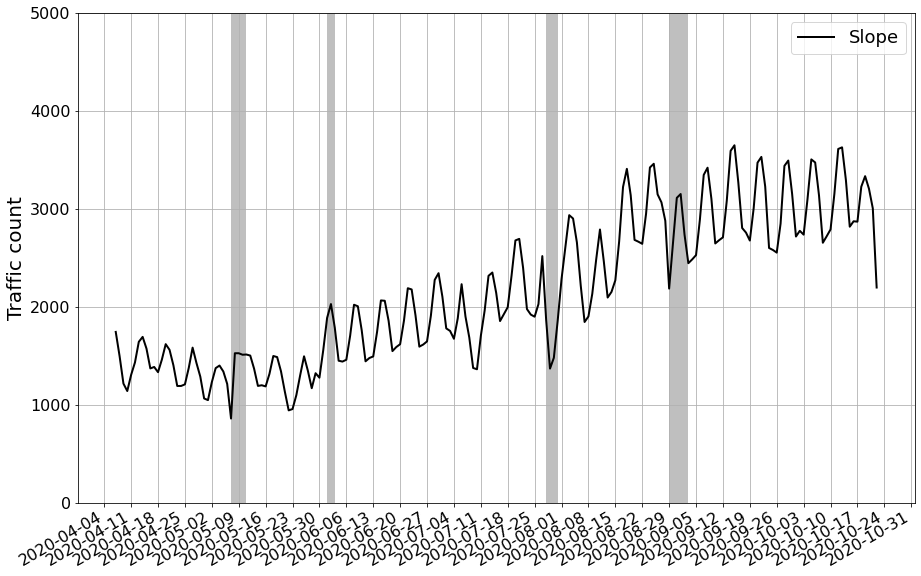

In [7]:
from traffic_events import *
from matplotlib import colors
import matplotlib as mpl
import pandas as pd

peaks_datapath='./S07_dA_peaks/'
peak_output_path_days='./Peak_S07_4days/'

for keys in [peak_output_path_days] :
    if not os.path.exists(keys):
        print('creat %s' %keys)
        os.makedirs(keys)
starttimep = UTCDateTime(2020,4,7,0,0,0)   # section begin time
endtimep   = UTCDateTime(2020,10,23,0,0,0)   # section begin time
nline_num = int((endtimep-starttimep)/oneday)  

daytime = []
for iline in range(0, nline_num):
    peak0=[]
    time_bg = starttimep + iline*time_diff1
    time_ed = time_bg+time_diff2
    peak_list = getdatalist(peaks_datapath, station, flag_peaks, time_bg, time_ed, cmp)
    if peak_list ==[]:
        continue
    else:
        daytime += [time_bg.datetime.date()]  # for legend
    
    for ipp in range(0, len(peak_list)):
        peak = np.load(peak_list[ipp])
        peak0.append(peak['data'])

    peak_days=np.sum((peak0))/len(peak0)
    
#     print(peak_days)
    peak_title = '%s-%s-%s-%s-%s'%(station,flag_peaks, time_bg.strftime("%Y.%m.%d.%H:%M:%S"),
                                  time_ed.strftime("%Y.%m.%d.%H:%M:%S"), cmp)
    path = peak_output_path_days + peak_title
    np.savez(path, data=peak_days, ax1=np.array([]), time=time_bg.strftime("%Y-%m-%d"), txt_hrd=peak_title)
    
    
ylim_min2 = 0;
ylim_max2 = 5000;

fig_size=(15,10)
fontsize=20

fig, ax = plt.subplots(figsize=fig_size)
daytime = []
line_num = 0
points_pks = []
peaks = []
time_line = []
time_line1 = []

peaks_list = getdatalist(peak_output_path_days, station, flag_peaks, starttime, endtime, cmp)
# print(len(Q_list),len(peaks_list))

S07_df_peaks=pd.DataFrame(columns=['time','Traffic Count'])
    
for ipp in range(0, len(peaks_list)):
    pks= np.load(peaks_list[ipp])
    time = datetime.datetime.strptime(np.array2string(pks['time']), "'%Y-%m-%d'")
    time1=time.strftime("%Y-%m-%d")
    S07_df_peaks.loc[ipp,'time']=time1
    S07_df_peaks.loc[ipp,'Traffic Count']=pks['data']
    peaks += [pks['data']]
    time_line += [time]

peaks=np.array(peaks)
S07_df_peaks.to_csv('./S07_df_peaks.csv')  
line1,=ax.plot(time_line,S07_df_peaks['Traffic Count'], color='k',linewidth=2,label='Slope')

# beautify the x-labels
myFmt = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(myFmt)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.set_ylabel('Traffic count', fontsize=fontsize)     
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_ylim([ylim_min2,ylim_max2])
# # ax.set_ylim(0,500)

ax.grid(True)
fig.autofmt_xdate() 

for dbi in datelist_without_data1:
    plt.axvspan(dbi, dbi+datetime.timedelta(days=1),
                facecolor='gray', edgecolor=None,
                alpha=0.5, zorder=-5)

for dbi in datelist_without_data2:
    plt.axvspan(dbi, dbi+datetime.timedelta(days=1),
                facecolor='gray', edgecolor=None,
                alpha=0.5, zorder=-5)
for dbi in datelist_without_data3:
    plt.axvspan(dbi, dbi+datetime.timedelta(days=1),
                facecolor='gray', edgecolor=None,
                alpha=0.5, zorder=-5)

for dbi in datelist_without_data4:
    plt.axvspan(dbi, dbi+datetime.timedelta(days=1),
                facecolor='gray', edgecolor=None,
                alpha=0.5, zorder=-5)
    
plt.legend(handles=[line1],fontsize=18)
plt.savefig("Figure_NUS_pks.jpg", bbox_inches = 'tight',dpi=600)
plt.show()


## Temperature

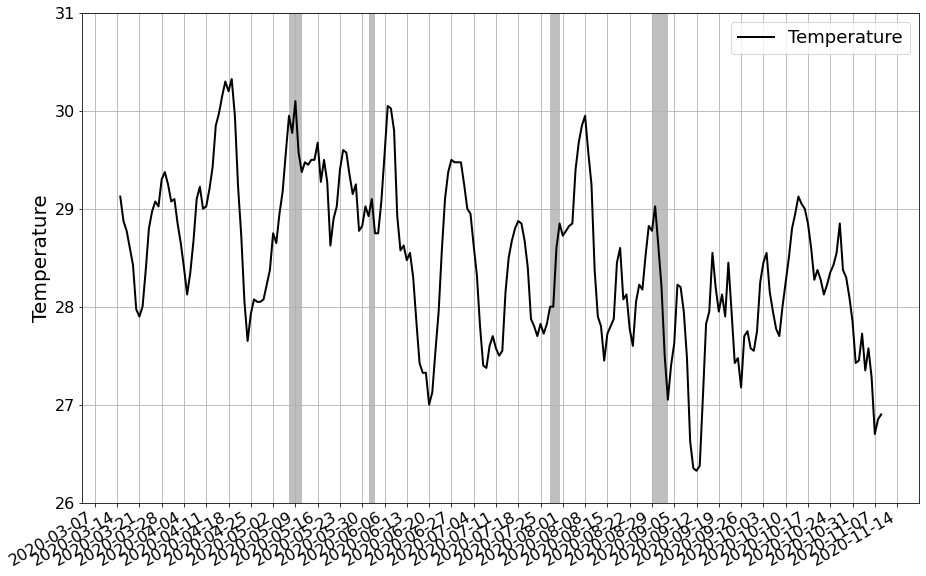

In [8]:
from traffic_events import *
from matplotlib import colors
import matplotlib as mpl

ylim_min2 = 26;
ylim_max2 = 31;
fig_size=(15,10)
fontsize=20

fig, ax = plt.subplots(figsize=fig_size)
daytime = []
line_num = 0
points0 = []
rainfall0=[]
time_line = []
temp0=[]
temp_list = getdatalist(rainfall_output_path_days, station, flag_temp, starttime, endtime, cmp)

S07_df_temp=pd.DataFrame(columns=['time','Temperature'])   
    
for ipp in range(0, len(temp_list)):
    temp= np.load(temp_list[ipp])
    time = datetime.datetime.strptime(np.array2string(temp['time']),"'%Y-%m-%d'") #"'%Y.%m.%d.%H:%M:%S'")
    time1=time.strftime("%Y-%m-%d")
    S07_df_temp.loc[ipp,'time']=time1
    S07_df_temp.loc[ipp,'Temperature']=temp['data']
    temp0+= [temp['data']]
    time_line += [time]

S07_df_temp.to_csv('./S07_df_temp.csv')  
temp0=np.array(temp0)
line1,=ax.plot(time_line,S07_df_temp['Temperature'], color='k',linewidth=2,label='Temperature')

# beautify the x-labels
myFmt = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(myFmt)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.set_ylabel('Temperature', fontsize=fontsize)    
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_ylim([ylim_min2,ylim_max2])
ax.grid(True)
fig.autofmt_xdate() 

for dbi in datelist_without_data1:
    plt.axvspan(dbi, dbi+datetime.timedelta(days=1),
                facecolor='gray', edgecolor=None,
                alpha=0.5, zorder=-5)

for dbi in datelist_without_data2:
    plt.axvspan(dbi, dbi+datetime.timedelta(days=1),
                facecolor='gray', edgecolor=None,
                alpha=0.5, zorder=-5)
for dbi in datelist_without_data3:
    plt.axvspan(dbi, dbi+datetime.timedelta(days=1),
                facecolor='gray', edgecolor=None,
                alpha=0.5, zorder=-5)

for dbi in datelist_without_data4:
    plt.axvspan(dbi, dbi+datetime.timedelta(days=1),
                facecolor='gray', edgecolor=None,
                alpha=0.5, zorder=-5)

plt.legend(handles=[line1],fontsize=18)
plt.savefig("Figure_NUS_temp.jpg", bbox_inches = 'tight',dpi=600)
plt.show()

# Results

## Q variations over time vs potential factors

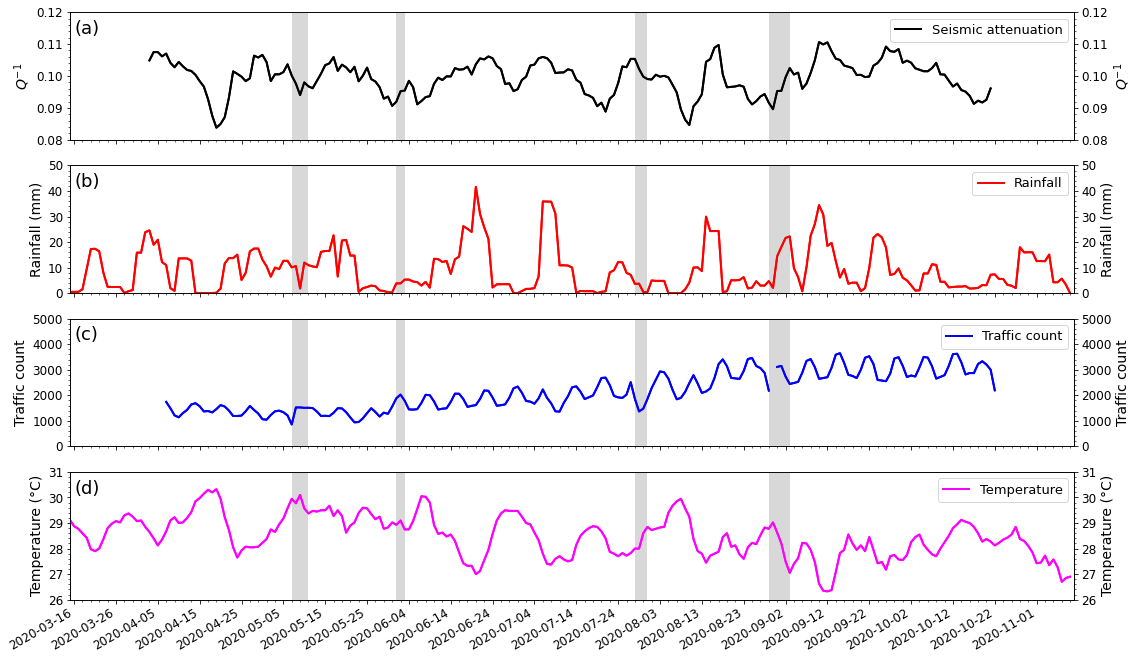

In [9]:

df1=pd.read_csv('S07_df_Q.csv')
df1.drop(['Unnamed: 0'], axis=1, inplace=True)

df2=pd.read_csv('S07_df_rf.csv')
df2.drop(['Unnamed: 0'], axis=1, inplace=True)

df3=pd.read_csv('S07_df_peaks.csv')
df3.drop(['Unnamed: 0'], axis=1, inplace=True) 
 
df4=pd.read_csv('S07_df_temp.csv')
df4.drop(['Unnamed: 0'], axis=1, inplace=True) 

S07_df1=df1.merge(df2, how='outer', on='time',sort=True)
S07_df2=S07_df1.merge(df3, how='outer', on='time',sort=True)
S07_df3=S07_df2.merge(df4, how='outer', on='time',sort=True)
S07_df3.to_csv('./S07_df.csv') 
df=pd.read_csv('S07_df.csv')

df.drop(['Unnamed: 0'], axis=1, inplace=True) 

fig, ax = plt.subplots(4,1,figsize=(18, 12))
letters='abcd'

df['time'] = list(map(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d"), df['time']))

ax[0].plot(df['time'], df['Q'], color='black', linewidth=2,label='Seismic attenuation')
ax[0].legend(fontsize=13)
ax[0].tick_params(bottom='on',left='on',right='on',labelright='on')
ax[0].minorticks_on()
ax[0].tick_params(axis='y', which='minor', right=True)
ax[0].set_ylabel('$Q^{-1}$',fontsize=14)
ax[0].set_ylim(0.08,0.12)
ax0=ax[0].twinx()
ax0.plot(df['time'], df['Q'], color='black', linewidth=2,label='Seismic attenuation')
ax0.minorticks_on()
ax0.tick_params(axis='y', which='minor', right=True)
ax0.set_ylabel('$Q^{-1}$',fontsize=14)
ax0.set_ylim(0.08,0.12)
ax[0].tick_params(axis='both', which='major', labelsize=12)
ax0.tick_params(axis='both', which='major', labelsize=12)
ax0.set_xlim(starttime._get_datetime(),endtime._get_datetime())

for dbi in datelist_without_data1:
    plt.axvspan(dbi, dbi+datetime.timedelta(days=1),
                facecolor='gray', edgecolor=None,
                alpha=0.3, zorder=-5)

for dbi in datelist_without_data2:
    plt.axvspan(dbi, dbi+datetime.timedelta(days=1),
                facecolor='gray', edgecolor=None,
                alpha=0.3, zorder=-5)
    
for dbi in datelist_without_data3:
    plt.axvspan(dbi, dbi+datetime.timedelta(days=1),
                facecolor='gray', edgecolor=None,
                alpha=0.3, zorder=-5)

for dbi in datelist_without_data4:
    plt.axvspan(dbi, dbi+datetime.timedelta(days=1),
                facecolor='gray', edgecolor=None,
                alpha=0.3, zorder=-5)


myFmt = mdates.DateFormatter('%Y-%m-%d')
ax[0].xaxis.set_major_formatter(myFmt)
ax[0].xaxis.set_major_locator(mdates.DayLocator(interval=10))
ax[0].text(x=0.005, y=0.94, transform=ax[0].transAxes, s="("+letters[0]+")", fontsize=18, 
                verticalalignment="top", bbox={"edgecolor": "w", "linewidth": 1, "facecolor": "w",})

ax[1].plot(df['time'], df['Rainfall'], color='r',linewidth=2, label='Rainfall')
ax[1].legend(fontsize=13)
ax[1].tick_params(bottom='on',left='on',right='on',labelright='on')
ax[1].minorticks_on()
ax[1].tick_params(axis='y', which='minor', right=True)
ax[1].set_ylabel('Rainfall (mm)',fontsize=14)
ax[1].set_ylim(0,50)
ax2=ax[1].twinx()
ax2.plot(df['time'], df['Rainfall'], color='r',linewidth=2, label='Rainfall')
ax2.minorticks_on()
ax2.tick_params(axis='y', which='minor', right=True)
ax2.set_ylabel('Rainfall (mm)',fontsize=14)

ax2.set_ylim(0,50)
ax[1].tick_params(axis='both', which='major', labelsize=12)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.set_xlim(starttime._get_datetime(),endtime._get_datetime())

for dbi in datelist_without_data1:
    plt.axvspan(dbi, dbi+datetime.timedelta(days=1),
                facecolor='gray', edgecolor=None,
                alpha=0.3, zorder=-5)


for dbi in datelist_without_data2:
    plt.axvspan(dbi, dbi+datetime.timedelta(days=1),
                facecolor='gray', edgecolor=None,
                alpha=0.3, zorder=-5)

for dbi in datelist_without_data3:
    plt.axvspan(dbi, dbi+datetime.timedelta(days=1),
                facecolor='gray', edgecolor=None,
                alpha=0.3, zorder=-5)

for dbi in datelist_without_data4:
    plt.axvspan(dbi, dbi+datetime.timedelta(days=1),
                facecolor='gray', edgecolor=None,
                alpha=0.3, zorder=-5)


myFmt = mdates.DateFormatter('%Y-%m-%d')
ax[1].xaxis.set_major_formatter(myFmt)
ax[1].xaxis.set_major_locator(mdates.DayLocator(interval=10))
ax[1].text(x=0.005, y=0.94, transform=ax[1].transAxes, s="("+letters[1]+")", fontsize=18, 
                verticalalignment="top", bbox={"edgecolor": "w", "linewidth": 1, "facecolor": "w",})

ax[2].plot(df['time'], df['Traffic Count'], color='b',linewidth=2, label='Traffic count')
ax[2].legend(fontsize=13)
ax[2].tick_params(bottom='on',left='on',right='on',labelright='on')
ax[2].minorticks_on()
ax[2].tick_params(axis='y', which='minor', right=True)
ax[2].set_ylabel('Traffic count',fontsize=14)
ax[2].set_ylim(0,5000)
ax3=ax[2].twinx()
ax3.plot(df['time'], df['Traffic Count'], color='b',linewidth=2,label='Traffic count')
ax3.minorticks_on()
ax3.tick_params(axis='y', which='minor', right=True)
ax3.set_ylabel('Traffic count',fontsize=14)

ax3.set_ylim(0,5000)
ax[2].tick_params(axis='both', which='major', labelsize=12)
ax3.tick_params(axis='both', which='major', labelsize=12)
ax3.set_xlim(starttime._get_datetime(),endtime._get_datetime())
for dbi in datelist_without_data1:
    plt.axvspan(dbi, dbi+datetime.timedelta(days=1),
                facecolor='gray', edgecolor=None,
                alpha=0.3, zorder=-5)

for dbi in datelist_without_data2:
    plt.axvspan(dbi, dbi+datetime.timedelta(days=1),
                facecolor='gray', edgecolor=None,
                alpha=0.3, zorder=-5)

for dbi in datelist_without_data3:
    plt.axvspan(dbi, dbi+datetime.timedelta(days=1),
                facecolor='gray', edgecolor=None,
                alpha=0.3, zorder=-5)

for dbi in datelist_without_data4:
    plt.axvspan(dbi, dbi+datetime.timedelta(days=1),
                facecolor='gray', edgecolor=None,
                alpha=0.3, zorder=-5)

myFmt = mdates.DateFormatter('%Y-%m-%d')
ax[2].xaxis.set_major_formatter(myFmt)
ax[2].xaxis.set_major_locator(mdates.DayLocator(interval=10))
ax[2].text(x=0.005, y=0.94, transform=ax[2].transAxes, s="("+letters[2]+")", fontsize=18, 
                verticalalignment="top", bbox={"edgecolor": "w", "linewidth": 1, "facecolor": "w",})


ax[3].plot(df['time'], df['Temperature'], color='magenta',linewidth=2,label='Temperature')
ax[3].legend(fontsize=13)
ax[3].tick_params(bottom='on',left='on',right='on',labelright='on')
ax[3].minorticks_on()
ax[3].tick_params(axis='y', which='minor', right=True)
ax[3].set_ylabel('Temperature (°C)',fontsize=14)
ax[3].set_ylim(26,31)

ax4=ax[3].twinx()
ax4.plot(df['time'], df['Temperature'], color='magenta',linewidth=2,label='Temperature')
ax4.minorticks_on()
ax4.tick_params(axis='y', which='minor', right=True)
ax4.set_ylabel('Temperature (°C)',fontsize=14)

ax4.set_ylim(26,31)
ax[3].tick_params(axis='both', which='major', labelsize=12)
ax4.tick_params(axis='both', which='major', labelsize=12)
ax4.set_xlim(starttime._get_datetime(),endtime._get_datetime())
for dbi in datelist_without_data1:
    plt.axvspan(dbi, dbi+datetime.timedelta(days=1),
                facecolor='gray', edgecolor=None,
                alpha=0.3, zorder=-5)

for dbi in datelist_without_data2:
    plt.axvspan(dbi, dbi+datetime.timedelta(days=1),
                facecolor='gray', edgecolor=None,
                alpha=0.3, zorder=-5)

for dbi in datelist_without_data3:
    plt.axvspan(dbi, dbi+datetime.timedelta(days=1),
                facecolor='gray', edgecolor=None,
                alpha=0.3, zorder=-5)

for dbi in datelist_without_data4:
    plt.axvspan(dbi, dbi+datetime.timedelta(days=1),
                facecolor='gray', edgecolor=None,
                alpha=0.3, zorder=-5)

myFmt = mdates.DateFormatter('%Y-%m-%d')
ax[3].xaxis.set_major_formatter(myFmt)
ax[3].xaxis.set_major_locator(mdates.DayLocator(interval=10))
ax[3].text(x=0.005, y=0.94, transform=ax[3].transAxes, s="("+letters[3]+")", fontsize=18, 
                verticalalignment="top", bbox={"edgecolor": "w", "linewidth": 1, "facecolor": "w",})

fig.autofmt_xdate()
plt.savefig("Figure_NUS_all.jpg", bbox_inches = 'tight',dpi=600)

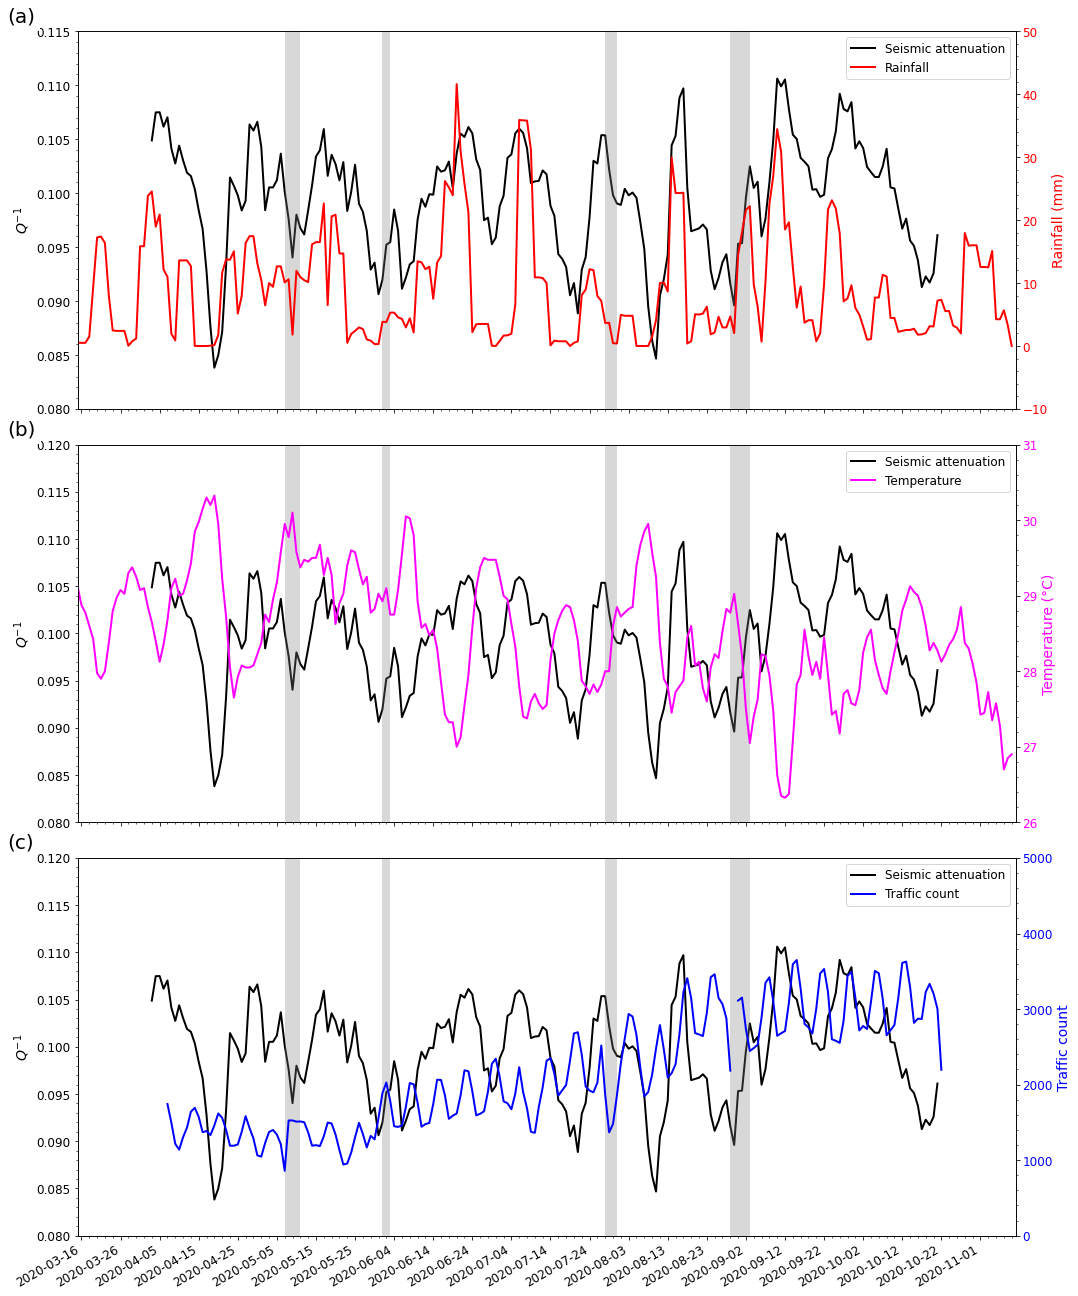

In [14]:
df1=pd.read_csv('S07_df_Q.csv')
df1.drop(['Unnamed: 0'], axis=1, inplace=True)

df2=pd.read_csv('S07_df_rf.csv')
df2.drop(['Unnamed: 0'], axis=1, inplace=True)

df3=pd.read_csv('S07_df_peaks.csv')
df3.drop(['Unnamed: 0'], axis=1, inplace=True) 
 
df4=pd.read_csv('S07_df_temp.csv')
df4.drop(['Unnamed: 0'], axis=1, inplace=True) 

S07_df1=df1.merge(df2, how='outer', on='time',sort=True)
S07_df2=S07_df1.merge(df3, how='outer', on='time',sort=True)
S07_df3=S07_df2.merge(df4, how='outer', on='time',sort=True)
S07_df3.to_csv('./S07_df.csv') 
df=pd.read_csv('S07_df.csv')

df.drop(['Unnamed: 0'], axis=1, inplace=True) 

fig, ax = plt.subplots(3,1,figsize=(15, 18))
letters='abcd'

df['time'] = list(map(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d"), df['time']))

line1, = ax[0].plot(df['time'], df['Q'], color='black', linewidth=2,label='Seismic attenuation')

ax[0].tick_params(bottom='on',left='on',right='on',labelright='on')
ax[0].minorticks_on()
ax[0].tick_params(axis='y', which='minor', right=True)
ax[0].set_ylabel('$Q^{-1}$',fontsize=14)
ax[0].set_ylim(0.08,0.115)
ax0=ax[0].twinx()
line2, = ax0.plot(df['time'], df['Rainfall'], color='r', linewidth=2, label='Rainfall')
ax0.minorticks_on()
ax0.tick_params(axis='y', which='minor', right=True)
ax0.set_ylabel('Rainfall (mm)',fontsize=14,color='r')
ax0.set_ylim(-10,50)
ax[0].tick_params(axis='both', which='major', labelsize=12)
ax0.tick_params(axis='both', which='major', labelsize=12,labelcolor='r')
ax0.set_xlim(starttime._get_datetime(),endtime._get_datetime())
plt.legend(handles=[line1, line2],fontsize=12)
for dbi in datelist_without_data1:
    plt.axvspan(dbi, dbi+datetime.timedelta(days=1),
                facecolor='gray', edgecolor=None,
                alpha=0.3, zorder=-5)

for dbi in datelist_without_data2:
    plt.axvspan(dbi, dbi+datetime.timedelta(days=1),
                facecolor='gray', edgecolor=None,
                alpha=0.3, zorder=-5)
    
for dbi in datelist_without_data3:
    plt.axvspan(dbi, dbi+datetime.timedelta(days=1),
                facecolor='gray', edgecolor=None,
                alpha=0.3, zorder=-5)

for dbi in datelist_without_data4:
    plt.axvspan(dbi, dbi+datetime.timedelta(days=1),
                facecolor='gray', edgecolor=None,
                alpha=0.3, zorder=-5)


myFmt = mdates.DateFormatter('%Y-%m-%d')
ax[0].xaxis.set_major_formatter(myFmt)
ax[0].xaxis.set_major_locator(mdates.DayLocator(interval=10))
ax[0].text(x=-0.075, y=1.065, transform=ax[0].transAxes, s="("+letters[0]+")", fontsize=20, 
                verticalalignment="top", bbox={"edgecolor": "w", "linewidth": 1, "facecolor": "w",})

line1, = ax[1].plot(df['time'], df['Q'], color='black',linewidth=2, label='Seismic attenuation')
ax[1].tick_params(bottom='on',left='on',right='on',labelright='on')
ax[1].minorticks_on()
ax[1].tick_params(axis='y', which='minor', right=True)
ax[1].set_ylabel('$Q^{-1}$',fontsize=14)
ax[1].set_ylim(0.08,0.12)
ax2=ax[1].twinx()
line2, = ax2.plot(df['time'], df['Temperature'], color='magenta',linewidth=2, label='Temperature')
ax2.minorticks_on()
ax2.tick_params(axis='y', which='minor', right=True)
ax2.set_ylabel('Temperature (°C)',fontsize=14,color='magenta')
ax2.set_ylim(26,31)
ax[1].tick_params(axis='both', which='major', labelsize=12)
ax2.tick_params(axis='both', which='major', labelsize=12,labelcolor='magenta')
ax2.set_xlim(starttime._get_datetime(),endtime._get_datetime())
plt.legend(handles=[line1, line2],fontsize=12)
for dbi in datelist_without_data1:
    plt.axvspan(dbi, dbi+datetime.timedelta(days=1),
                facecolor='gray', edgecolor=None,
                alpha=0.3, zorder=-5)


for dbi in datelist_without_data2:
    plt.axvspan(dbi, dbi+datetime.timedelta(days=1),
                facecolor='gray', edgecolor=None,
                alpha=0.3, zorder=-5)

for dbi in datelist_without_data3:
    plt.axvspan(dbi, dbi+datetime.timedelta(days=1),
                facecolor='gray', edgecolor=None,
                alpha=0.3, zorder=-5)

for dbi in datelist_without_data4:
    plt.axvspan(dbi, dbi+datetime.timedelta(days=1),
                facecolor='gray', edgecolor=None,
                alpha=0.3, zorder=-5)


myFmt = mdates.DateFormatter('%Y-%m-%d')
ax[1].xaxis.set_major_formatter(myFmt)
ax[1].xaxis.set_major_locator(mdates.DayLocator(interval=10))
ax[1].text(x=-0.075, y=1.065, transform=ax[1].transAxes, s="("+letters[1]+")", fontsize=20, 
                verticalalignment="top", bbox={"edgecolor": "w", "linewidth": 1, "facecolor": "w",})

line1, = ax[2].plot(df['time'], df['Q'], color='black',linewidth=2, label='Seismic attenuation')
ax[2].tick_params(bottom='on',left='on',right='on',labelright='on')
ax[2].minorticks_on()
ax[2].tick_params(axis='y', which='minor', right=True)
ax[2].set_ylabel('$Q^{-1}$',fontsize=14)
ax[2].set_ylim(0.08,0.12)
ax3=ax[2].twinx()
line2, = ax3.plot(df['time'], df['Traffic Count'], color='b',linewidth=2,label='Traffic count')
ax3.minorticks_on()
ax3.tick_params(axis='y', which='minor', right=True)
ax3.set_ylabel('Traffic count',fontsize=14,color='b')

ax3.set_ylim(0,5000)
ax[2].tick_params(axis='both', which='major', labelsize=12)
ax3.tick_params(axis='both', which='major', labelsize=12,labelcolor='b')
ax3.set_xlim(starttime._get_datetime(),endtime._get_datetime())
plt.legend(handles=[line1, line2],fontsize=12)

for dbi in datelist_without_data1:
    plt.axvspan(dbi, dbi+datetime.timedelta(days=1),
                facecolor='gray', edgecolor=None,
                alpha=0.3, zorder=-5)

for dbi in datelist_without_data2:
    plt.axvspan(dbi, dbi+datetime.timedelta(days=1),
                facecolor='gray', edgecolor=None,
                alpha=0.3, zorder=-5)

for dbi in datelist_without_data3:
    plt.axvspan(dbi, dbi+datetime.timedelta(days=1),
                facecolor='gray', edgecolor=None,
                alpha=0.3, zorder=-5)

for dbi in datelist_without_data4:
    plt.axvspan(dbi, dbi+datetime.timedelta(days=1),
                facecolor='gray', edgecolor=None,
                alpha=0.3, zorder=-5)

myFmt = mdates.DateFormatter('%Y-%m-%d')
ax[2].xaxis.set_major_formatter(myFmt)
ax[2].xaxis.set_major_locator(mdates.DayLocator(interval=10))
ax[2].text(x=-0.075, y=1.065, transform=ax[2].transAxes, s="("+letters[2]+")", fontsize=20, 
                verticalalignment="top", bbox={"edgecolor": None, "linewidth": 0, "facecolor": "w",})

fig.autofmt_xdate()
fig.tight_layout()
plt.savefig("Figure_NUS_all_new.jpg", bbox_inches = 'tight',dpi=600)

## Cross-correlation between Q and potential factors

In [10]:
def bpfilt(s,bp):
    r'''
    1D or 2D band-pass filter:
        input: 
            s-input waveform (1D, nt-by- or 2D, nt-by-nr)
            bp-band pass cut frequency relative to Nyquist (1D, (4-by-))
        output:
            y-output waveform (1D, nt-by- or 2D, nt-by-nr)
    '''
    D = np.array(s.shape)
    if D.size == 2:
        # 2D case
        nt,nr = D[:]
    else:
        # 1D case
        nt = D[0]
        nr = 1
    f = np.fft.fftfreq(nt,0.5)
    nh = (nt+1)//2
    w = np.zeros(f.shape)
    mask = (np.abs(f)>=bp[0]) * (np.abs(f)<bp[1])
    w[mask] = (np.abs(f[mask])-bp[0])/(bp[1]-bp[0])
    mask = (np.abs(f)>=bp[1]) * (np.abs(f)<bp[2])
    w[mask] = 1
    mask = (np.abs(f)>=bp[2]) * (np.abs(f)<bp[3])
    w[mask] = (np.abs(f[mask])-bp[3])/(bp[2]-bp[3])
    if nr == 1:
        S = np.fft.fft(s)
        y = np.fft.ifft(S*w).real
    else:
        S = np.fft.fft(s,axis=0)
        Y = S*(np.tile(w,(nr,1)).transpose())
        y = np.fft.ifft(Y,axis=0).real
    return y

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df1 = pd.read_csv('S07_df_Q.csv')
df1.drop(['Unnamed: 0'], axis=1, inplace=True)

df2 = pd.read_csv('S07_df_rf.csv')
df2.drop(['Unnamed: 0'], axis=1, inplace=True)

df3 = pd.read_csv('S07_df_peaks.csv')
df3.drop(['Unnamed: 0'], axis=1, inplace=True) 
 
df4 = pd.read_csv('S07_df_temp.csv')
df4.drop(['Unnamed: 0'], axis=1, inplace=True) 


S07_df1 = df1.merge(df2, how='outer', on='time',sort=True)
S07_df2 = S07_df1.merge(df3, how='outer', on='time',sort=True)
S07_df3 = S07_df2.merge(df4, how='outer', on='time',sort=True)
S07_df3 = S07_df3[(S07_df3['time'] > '2020-04-06') & (S07_df3['time'] < '2020-10-21')]

S07_df3.to_csv('./S07_df.csv') 
df = pd.read_csv('S07_df.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True) 

df = df.dropna()


### $Q^{-1}$ and rainfall

0.603703950746


Text(0.5, 1.0, 'max correlation is at lag 1')

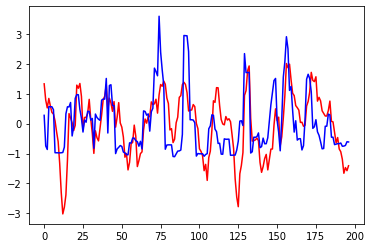

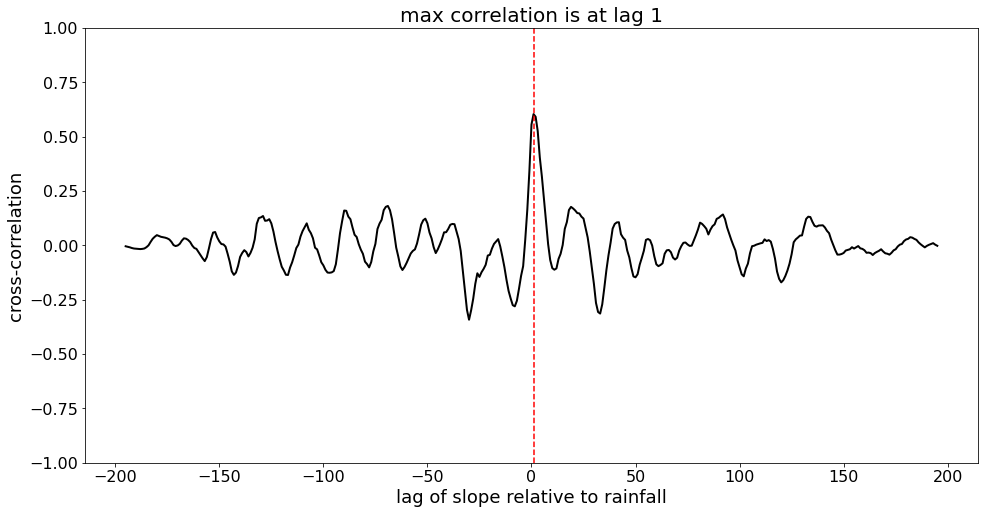

In [12]:
y01 = df['Q']
y02 = df['Rainfall']

y11 = bpfilt(y01,[0,0,0.01,0.02])
dy1 = y01-y11
y21 = bpfilt(y02,[0,0,0.01,0.02])
dy2 = y02-y21
plt.plot(dy1/dy1.std(),'r')
plt.plot(dy2/dy2.std(),'b')

y01 = y01-y11
y02 = y02-y21

lc = 30
lg = np.arange(0, lc+1)

npts_0 = len(y01)
lags_0 = np.arange(-npts_0+1, npts_0)
ccov0 = np.correlate(y01 - y01.mean(), y02 - y02.mean(), mode='full')
ccor_0 = ccov0 / (npts_0 * y01.std() * y02.std())
maxlag = lg[np.argmax(abs(ccor_0[npts_0-1:npts_0+lc]))]
print(max(abs(ccor_0[npts_0-1:npts_0+lc])))

fig, ax = plt.subplots(figsize=(16,8))
ax.plot(lags_0, ccor_0,color='k',linewidth=2)
ax.axvline(maxlag,color='r',linestyle='--',label='Peak synchrony')
ax.set_ylabel('cross-correlation',fontsize=18)
ax.set_xlabel('lag of slope relative to rainfall',fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_ylim(-1, 1)
plt.title("max correlation is at lag %d" % maxlag, fontsize=20)

### $Q^{-1}$ and traffic count

0.189584630246


Text(0.5, 1.0, 'max correlation is at lag 11')

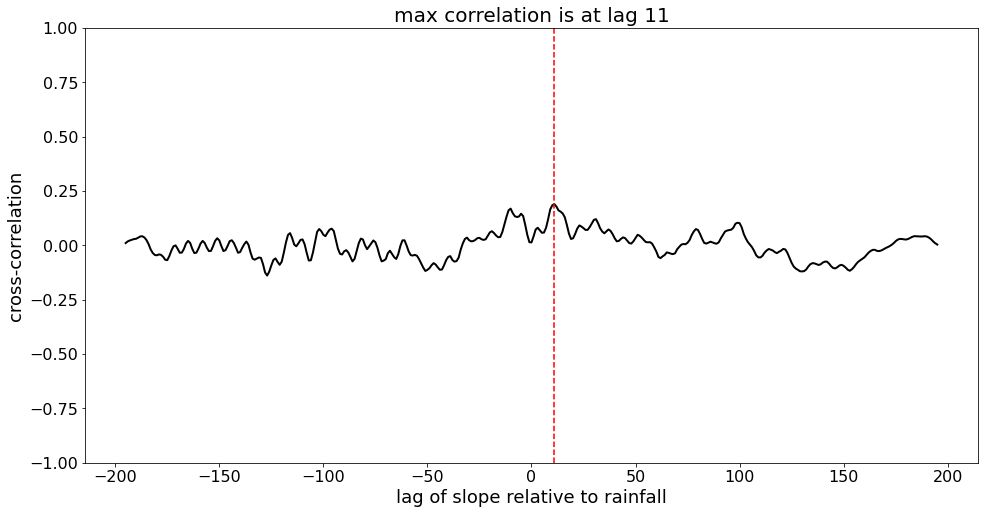

In [13]:
y01 = df['Q']
y02 = df['Traffic Count']

lc = 200
lg = np.arange(0, lc + 1)
npts_0 = len(y01)
lags_0 =  np.arange(-npts_0+1, npts_0)
ccov0 = np.correlate(y01 - y01.mean(), y02 - y02.mean(), mode='full')
ccor_0 = ccov0 / (npts_0 * y01.std() * y02.std())
maxlag = lg[np.argmax((ccor_0[npts_0-1:npts_0+lc]))]
print(max((ccor_0[npts_0-1:npts_0+lc])))
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(lags_0, ccor_0,color='k',linewidth=2)
ax.axvline(maxlag,color='r',linestyle='--',label='Peak synchrony')
ax.set_ylabel('cross-correlation',fontsize=18)
ax.set_xlabel('lag of slope relative to rainfall',fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_ylim(-1, 1)
plt.title("max correlation is at lag %d" % maxlag, fontsize=20)

### $Q^{-1}$ and temperature

0.620078764723


Text(0.5, 1.0, 'max correlation is at lag 1')

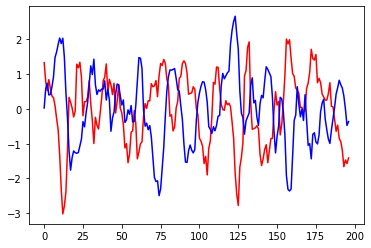

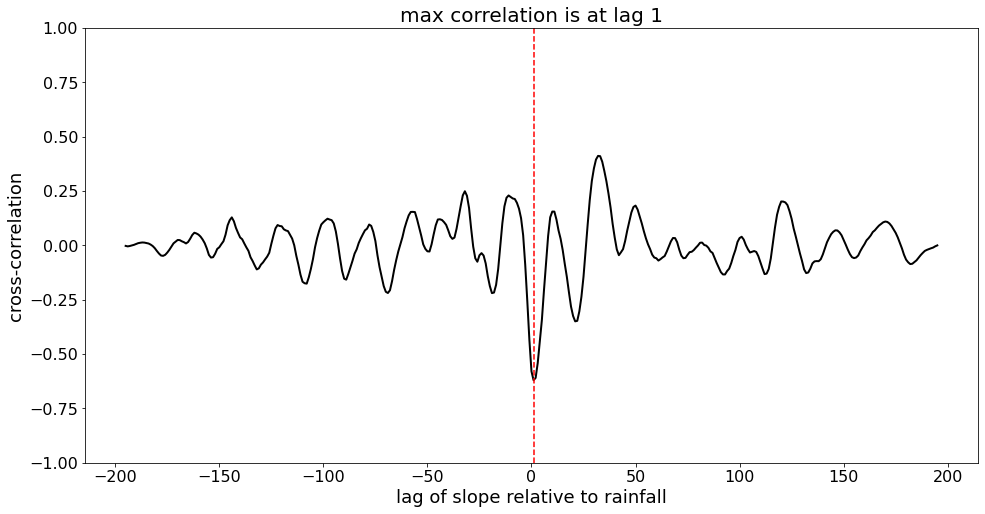

In [14]:
y01 = df['Q']
y02 = df['Temperature']
y11 = bpfilt(y01,[0,0,0.01,0.02])
dy1 = y01-y11
y21 = bpfilt(y02,[0,0,0.01,0.02])
dy2 = y02-y21
plt.plot(dy1/dy1.std(),'r')
plt.plot(dy2/dy2.std(),'b')
y01 = y01-y11
y02 = y02-y21
lc = 150
lg = np.arange(0, lc+1)
npts_0 = len(y01)
lags_0 = np.arange(-npts_0+1, npts_0)
ccov0 = np.correlate(y01 - y01.mean(), y02 - y02.mean(), mode='full')
ccor_0 = ccov0 / (npts_0 * y01.std() * y02.std())
maxlag = lg[np.argmax(abs(ccor_0[npts_0-1:npts_0+lc]))]
print(max(abs(ccor_0[npts_0-1:npts_0+lc])))
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(lags_0, ccor_0,color='k',linewidth=2)
ax.axvline(maxlag,color='r',linestyle='--',label='Peak synchrony')
ax.set_ylabel('cross-correlation',fontsize=18)
ax.set_xlabel('lag of slope relative to rainfall',fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_ylim(-1, 1)
plt.title("max correlation is at lag %d" % maxlag, fontsize=20)

### $rainfall and temperature

0.653250410023


Text(0.5, 1.0, 'max correlation is at lag 0')

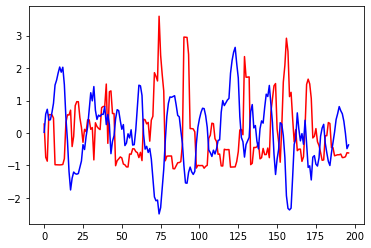

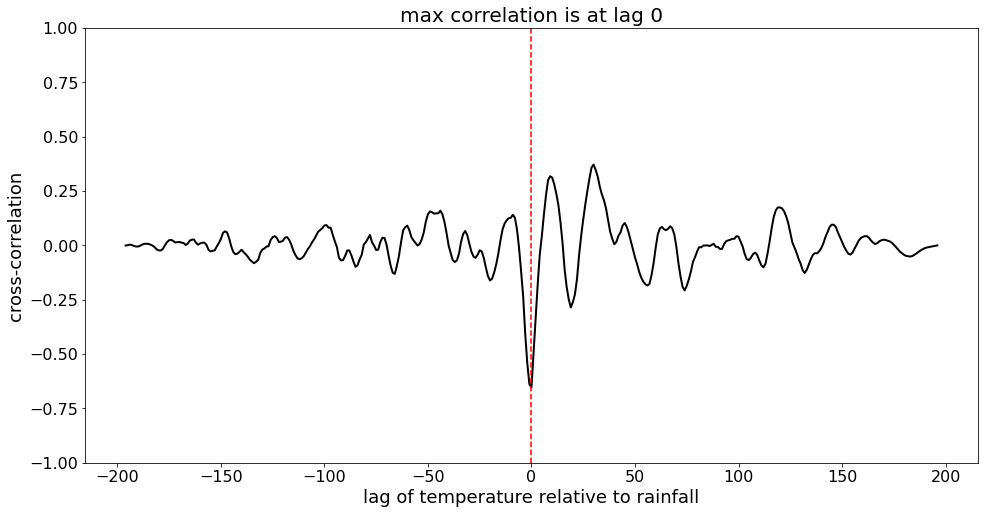

In [15]:
df = pd.read_csv('S07_df.csv')
df = df[:199]
y01 = df['Rainfall']
y02 = df['Temperature']
y11 = bpfilt(y01,[0,0,0.01,0.02])
dy1 = y01-y11
y21 = bpfilt(y02,[0,0,0.01,0.02])
dy2 = y02-y21
plt.plot(dy1/dy1.std(),'r')
plt.plot(dy2/dy2.std(),'b')
y01 = y01-y11
y02 = y02-y21

lc = 7
lg = np.arange(0, lc+1)
npts_0 = len(y01)
lags_0 = np.arange(-npts_0+1, npts_0)
ccov0 = np.correlate(y01 - y01.mean(), y02 - y02.mean(), mode='full')
ccor_0 = ccov0 / (npts_0 * y01.std() * y02.std())
maxlag = lg[np.argmax(abs(ccor_0[npts_0-1:npts_0+lc]))]
print(max(abs(ccor_0[npts_0-1:npts_0+lc])))

fig, ax = plt.subplots(figsize=(16,8))
ax.plot(lags_0, ccor_0,color='k',linewidth=2)
ax.axvline(maxlag,color='r',linestyle='--',label='Peak synchrony')
ax.set_ylabel('cross-correlation',fontsize=18)
ax.set_xlabel('lag of temperature relative to rainfall',fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_ylim(-1, 1)
plt.title("max correlation is at lag %d" % maxlag, fontsize=20)

## Shorter window cross-correlations

### time window size=5

Text(0, 0.5, 'Percentage')

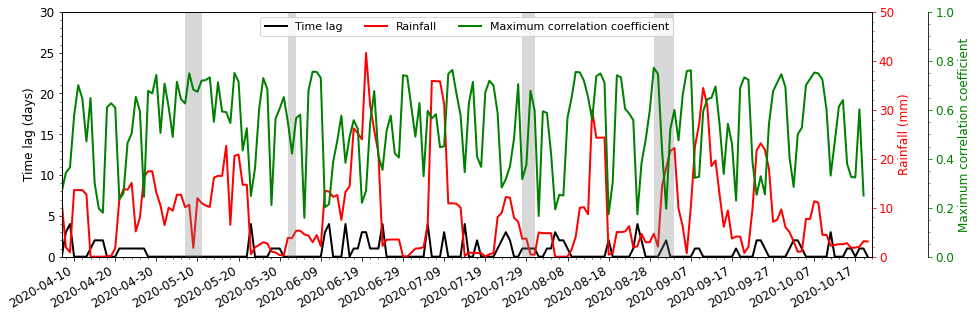

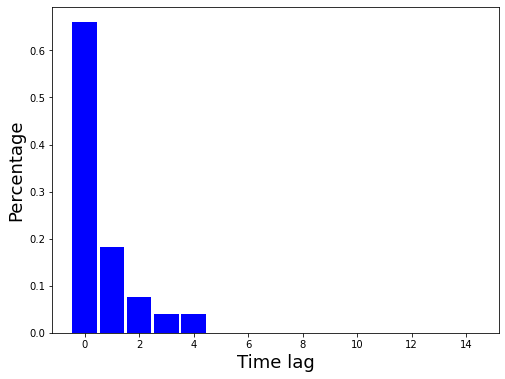

In [16]:
starttime = UTCDateTime(2020,4,7,0,0,0)   # section begin time
endtime   = UTCDateTime(2020,10,21,0,0,0)   # section begin time

df1 = pd.read_csv('S07_df_Q.csv')
df1.drop(['Unnamed: 0'], axis=1, inplace=True)

df2 = pd.read_csv('S07_df_rf.csv')
df2.drop(['Unnamed: 0'], axis=1, inplace=True)

df3 = pd.read_csv('S07_df_peaks.csv')
df3.drop(['Unnamed: 0'], axis=1, inplace=True) 
 
df4 = pd.read_csv('S07_df_temp.csv')
df4.drop(['Unnamed: 0'], axis=1, inplace=True) 


S07_df1 = df1.merge(df2, how='outer', on='time',sort=True)
S07_df2 = S07_df1.merge(df3, how='outer', on='time',sort=True)
S07_df3 = S07_df2.merge(df4, how='outer', on='time',sort=True)
S07_df3 = S07_df3[(S07_df3['time'] > '2020-04-06') & (S07_df3['time'] < '2020-10-21')]

S07_df3.to_csv('./S07_df.csv') 
df = pd.read_csv('S07_df.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True) 


tw = 5
tl = np.zeros(len(df))
maxc = np.zeros(len(df))

y01 = df['Q'].interpolate()
y02 = df['Rainfall'].interpolate()
y11 = bpfilt(y01,[0,0,0.01,0.02])
y21 = bpfilt(y02,[0,0,0.01,0.02])

y01 = y01-y11
y02 = y02-y21

for i in range(len(df)):
    s1 = y01[i:i+tw]
    s2 = y02[i:i+tw]
    lc = tw
    lg = np.arange(0, lc+1)
    npts = len(s1)
    lags = np.arange(-npts+1, npts)
    ccov = np.correlate(s1 - s1.mean(), s2 - s2.mean(), mode='full')
    ccor = ccov / (npts * s1.std() * s2.std())
    maxlag = lg[np.argmax((ccor[npts-1:npts+lc]))]
    maxc[i] = max((ccor[npts-1:npts+lc]))
    tl[i] = maxlag

df['time_lags'] = tl
df['maxc'] = maxc
df.to_csv('./S07_df_all.csv') 

fig, ax = plt.subplots(figsize=(18, 5))
fig.subplots_adjust(right=0.75)
df['time'] = list(map(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d"), df['time']))
l1,=ax.plot(df['time'], df['time_lags'], color = 'black', linewidth = 2,label = 'Time lag')
ax.tick_params(bottom = 'on',left = 'on',right = 'on',labelright='on')
ax.minorticks_on()
ax.tick_params(axis = 'y', which='minor', right=True)
ax.set_ylabel('Time lag (days)',fontsize=12)
ax.set_ylim(0,30)
ax0=ax.twinx()
l2,=ax0.plot(df['time'], df['Rainfall'], color='red', linewidth=2,label = 'Rainfall (mm)')
ax0.minorticks_on()
ax0.tick_params(axis='y', which='minor', right=True,color='red')
ax0.set_ylabel('Rainfall (mm)',fontsize = 12,color = 'red')

ax0.set_ylim(0,50)
ax.tick_params(axis = 'both', which = 'major', labelsize = 12)
ax0.tick_params(axis = 'both', which = 'major', labelsize = 12,labelcolor = 'red',color = 'red')
ax0.set_xlim(starttime._get_datetime(),endtime._get_datetime())


ax1=ax.twinx()
ax1.spines['right'].set_position(("axes", 1.07))
l3,=ax1.plot(df['time'], df['maxc'], color='g', linewidth=2,label='Maximum correlation coefficient')
ax1.minorticks_on()
ax1.tick_params(axis = 'y', which = 'minor', right = True,color = 'g')
ax1.set_ylabel('Maximum correlation coefficient',fontsize=12, color='g')
plt.legend([l1,l2,l3],['Time lag','Rainfall','Maximum correlation coefficient'],ncol=3,loc='upper center',fontsize=11)
ax1.set_ylim(0,1)
ax1.tick_params(axis = 'both', which = 'major', labelsize = 12,labelcolor = 'g',color = 'g')
ax1.set_xlim(starttime._get_datetime(),endtime._get_datetime())


for dbi in datelist_without_data1:
    plt.axvspan(dbi, dbi+datetime.timedelta(days=1),
                facecolor='gray', edgecolor=None,
                alpha=0.3, zorder=-5)
    
for dbi in datelist_without_data2:
    plt.axvspan(dbi, dbi+datetime.timedelta(days=1),
                facecolor='gray', edgecolor=None,
                alpha=0.3, zorder=-5)
for dbi in datelist_without_data3:
    plt.axvspan(dbi, dbi+datetime.timedelta(days=1),
                facecolor='gray', edgecolor=None,
                alpha=0.3, zorder=-5)

for dbi in datelist_without_data4:
    plt.axvspan(dbi, dbi+datetime.timedelta(days=1),
                facecolor='gray', edgecolor=None,
                alpha=0.3, zorder=-5)


myFmt = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(myFmt)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))
fig.autofmt_xdate()

plt.savefig("Figure_NUS_cc_tw5.jpg", bbox_inches = 'tight',dpi=600)

fig, ax = plt.subplots(figsize=(8, 6))
plt.hist(df['time_lags'],bins=15,range=(0,15),align='left',color='blue',rwidth=0.9,density=True)
plt.xlabel("Time lag",fontsize=18)
plt.ylabel("Percentage",fontsize=18)

In [17]:
df = pd.read_csv('S07_df_all.csv')
df1 = df.groupby(['time_lags']).size()
df1
a_15 = np.array([130,36,15,8,8,0,0,0,0,0,0,0,0,0,0])
a = df1.tolist()
a
df1

time_lags
0.0    130
1.0     36
2.0     15
3.0      8
4.0      8
dtype: int64

In [18]:
df = pd.read_csv('S07_df_all.csv')

df1 = pd.DataFrame(df.loc[df['maxc'] >= 0.5])#.boxplot(column='ccs',by='time_lags')
df2 = df1.groupby(['time_lags']).size()
b_15 = np.array([103,18,0,0,1,0,0,0,0,0,0,0,0,0,0])
b = df2.tolist()
df2

time_lags
0.0    103
1.0     18
4.0      1
dtype: int64

In [19]:
from matplotlib.ticker import PercentFormatter
df = pd.read_csv('S07_df_all.csv')
ltl = len(df['time_lags'])
x1 = b_15/ltl*100
x2 = (a_15-b_15)/ltl*100
x = np.vstack((x1,x2))
x
aa = np.arange(0,15)
aa

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

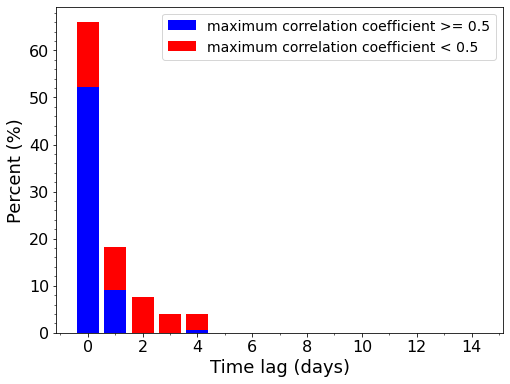

In [20]:
from matplotlib.ticker import MultipleLocator
fig, ax = plt.subplots(figsize=(8, 6))

p1=plt.bar(aa,x1,color = 'b',label = 'maximum correlation coefficient >= 0.5')
p2=plt.bar(aa,x2,bottom = x1,color= 'r',label = 'maximum correlation coefficient < 0.5')
plt.xlabel("Time lag (days)",fontsize = 18)
plt.ylabel("Percent (%)",fontsize = 18)
plt.legend(fontsize = 14)
ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
ax.minorticks_on()
ax.xaxis.set_major_locator(MultipleLocator(2))  # major ticks every 100 (optional)
ax.xaxis.set_minor_locator(MultipleLocator(1))   # minor ticks every 10
# ax.tick_params(axis='x', which='minor', bottom=False)#disable x minor ticks
# plt.gca().yaxis.set_major_formatter(PercentFormatter(1)) 
plt.savefig("Figure_NUS_hist_tw5.jpg", bbox_inches = 'tight',dpi=600)

### time window size=15

Text(0, 0.5, 'Percentage')

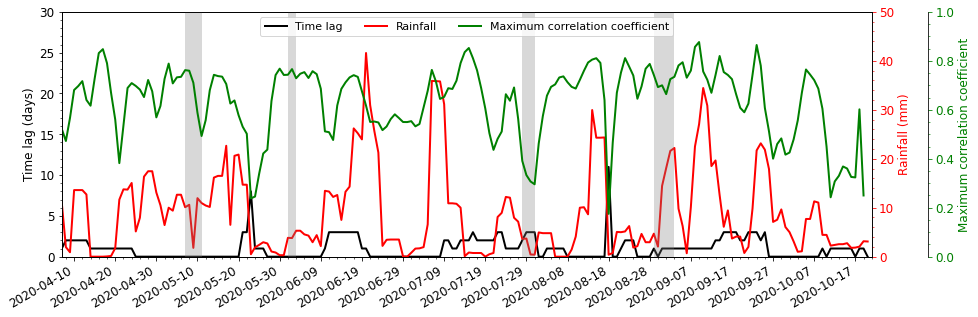

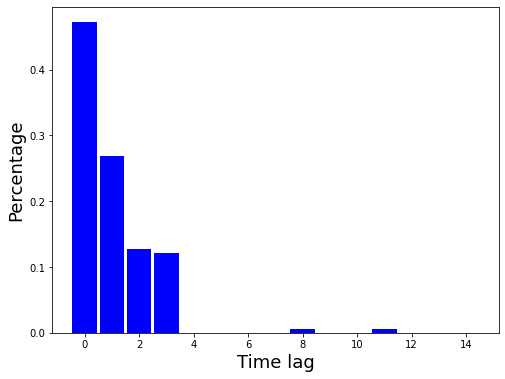

In [21]:
df1 = pd.read_csv('S07_df_Q.csv')
df1.drop(['Unnamed: 0'], axis=1, inplace=True)

df2 = pd.read_csv('S07_df_rf.csv')
df2.drop(['Unnamed: 0'], axis=1, inplace=True)

df3 = pd.read_csv('S07_df_peaks.csv')
df3.drop(['Unnamed: 0'], axis=1, inplace=True) 
 
df4 = pd.read_csv('S07_df_temp.csv')
df4.drop(['Unnamed: 0'], axis=1, inplace=True) 


S07_df1 = df1.merge(df2, how='outer', on='time',sort=True)
S07_df2 = S07_df1.merge(df3, how='outer', on='time',sort=True)
S07_df3 = S07_df2.merge(df4, how='outer', on='time',sort=True)
S07_df3 = S07_df3[(S07_df3['time'] > '2020-04-06') & (S07_df3['time'] < '2020-10-21')]

S07_df3.to_csv('./S07_df.csv') 
df = pd.read_csv('S07_df.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True) 


tw = 15
tl = np.zeros(len(df))
maxc = np.zeros(len(df))

y01 = df['Q'].interpolate()
y02 = df['Rainfall'].interpolate()
y11 = bpfilt(y01,[0,0,0.01,0.02])
y21 = bpfilt(y02,[0,0,0.01,0.02])

y01 = y01-y11
y02 = y02-y21

for i in range(len(df)):
    s1 = y01[i:i+tw]
    s2 = y02[i:i+tw]
    lc = tw
    lg = np.arange(0, lc+1)
    npts = len(s1)
    lags = np.arange(-npts+1, npts)
    ccov = np.correlate(s1 - s1.mean(), s2 - s2.mean(), mode='full')
    ccor = ccov / (npts * s1.std() * s2.std())
    maxlag = lg[np.argmax((ccor[npts-1:npts+lc]))]
    maxc[i] = max((ccor[npts-1:npts+lc]))
    tl[i] = maxlag

df['time_lags'] = tl
df['maxc'] = maxc
df.to_csv('./S07_df_all.csv') 

fig, ax = plt.subplots(figsize=(18, 5))
fig.subplots_adjust(right=0.75)
df['time'] = list(map(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d"), df['time']))
l1,=ax.plot(df['time'], df['time_lags'], color = 'black', linewidth = 2,label = 'Time lag')
ax.tick_params(bottom = 'on',left = 'on',right = 'on',labelright='on')
ax.minorticks_on()
ax.tick_params(axis = 'y', which='minor', right=True)
ax.set_ylabel('Time lag (days)',fontsize=12)
ax.set_ylim(0,30)
ax0=ax.twinx()
l2,=ax0.plot(df['time'], df['Rainfall'], color='red', linewidth=2,label = 'Rainfall (mm)')
ax0.minorticks_on()
ax0.tick_params(axis='y', which='minor', right=True,color='red')
ax0.set_ylabel('Rainfall (mm)',fontsize = 12,color = 'red')

ax0.set_ylim(0,50)
ax.tick_params(axis = 'both', which = 'major', labelsize = 12)
ax0.tick_params(axis = 'both', which = 'major', labelsize = 12,labelcolor = 'red',color = 'red')
ax0.set_xlim(starttime._get_datetime(),endtime._get_datetime())


ax1=ax.twinx()
ax1.spines['right'].set_position(("axes", 1.07))
l3,=ax1.plot(df['time'], df['maxc'], color='g', linewidth=2,label='Maximum correlation coefficient')
ax1.minorticks_on()
ax1.tick_params(axis = 'y', which = 'minor', right = True,color = 'g')
ax1.set_ylabel('Maximum correlation coefficient',fontsize=12, color='g')
plt.legend([l1,l2,l3],['Time lag','Rainfall','Maximum correlation coefficient'],ncol=3,loc='upper center',fontsize=11)
ax1.set_ylim(0,1)
ax1.tick_params(axis = 'both', which = 'major', labelsize = 12,labelcolor = 'g',color = 'g')
ax1.set_xlim(starttime._get_datetime(),endtime._get_datetime())


for dbi in datelist_without_data1:
    plt.axvspan(dbi, dbi+datetime.timedelta(days=1),
                facecolor='gray', edgecolor=None,
                alpha=0.3, zorder=-5)
    
for dbi in datelist_without_data2:
    plt.axvspan(dbi, dbi+datetime.timedelta(days=1),
                facecolor='gray', edgecolor=None,
                alpha=0.3, zorder=-5)
for dbi in datelist_without_data3:
    plt.axvspan(dbi, dbi+datetime.timedelta(days=1),
                facecolor='gray', edgecolor=None,
                alpha=0.3, zorder=-5)

for dbi in datelist_without_data4:
    plt.axvspan(dbi, dbi+datetime.timedelta(days=1),
                facecolor='gray', edgecolor=None,
                alpha=0.3, zorder=-5)


myFmt = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(myFmt)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))
fig.autofmt_xdate()

plt.savefig("Figure_NUS_cc_tw15.jpg", bbox_inches = 'tight',dpi=600)

fig, ax = plt.subplots(figsize=(8, 6))
plt.hist(df['time_lags'],bins=15,range=(0,15),align='left',color='blue',rwidth=0.9,density=True)
plt.xlabel("Time lag",fontsize=18)
plt.ylabel("Percentage",fontsize=18)

In [22]:
df = pd.read_csv('S07_df_all.csv')
df1 = df.groupby(['time_lags']).size()
df1
a_15 = np.array([93,53,25,24,0,0,0,0,1,0,0,1,0,0,0])
a = df1.tolist()
a
df1

time_lags
0.0     93
1.0     53
2.0     25
3.0     24
8.0      1
11.0     1
dtype: int64

In [23]:
df = pd.read_csv('S07_df_all.csv')

df1 = pd.DataFrame(df.loc[df['maxc'] >= 0.5])#.boxplot(column='ccs',by='time_lags')
df2 = df1.groupby(['time_lags']).size()
b_15 = np.array([80,42,22,19,0,0,0,0,0,0,0,0,0,0,0])
b = df2.tolist()
df2

time_lags
0.0    80
1.0    42
2.0    22
3.0    19
dtype: int64

In [24]:
from matplotlib.ticker import PercentFormatter
df = pd.read_csv('S07_df_all.csv')
ltl = len(df['time_lags'])

In [25]:
x1 = b_15/ltl*100
x2 = (a_15-b_15)/ltl*100
x = np.vstack((x1,x2))
x
aa = np.arange(0,15)
aa

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

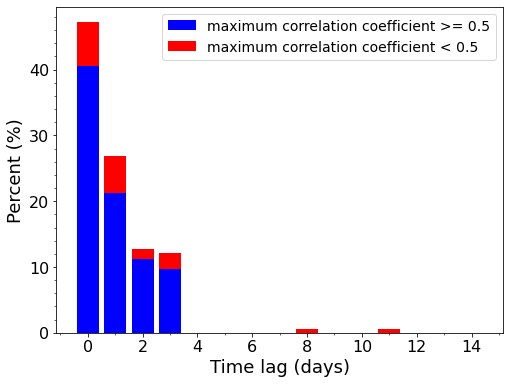

In [26]:
from matplotlib.ticker import MultipleLocator
fig, ax = plt.subplots(figsize=(8, 6))

p1=plt.bar(aa, x1, color = 'b',label = 'maximum correlation coefficient >= 0.5')
p2=plt.bar(aa, x2, bottom = x1,color = 'r',label = 'maximum correlation coefficient < 0.5')
plt.xlabel("Time lag (days)",fontsize = 18)
plt.ylabel("Percent (%)",fontsize = 18)
plt.legend(fontsize = 14)
ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
ax.minorticks_on()
ax.xaxis.set_major_locator(MultipleLocator(2))  # major ticks every 100 (optional)
ax.xaxis.set_minor_locator(MultipleLocator(1))   # minor ticks every 10
# ax.tick_params(axis='x', which='minor', bottom=False)#disable x minor ticks
# plt.gca().yaxis.set_major_formatter(PercentFormatter(1)) 
plt.savefig("Figure_NUS_hist_tw15.jpg", bbox_inches = 'tight',dpi=600)